# Deep Hedging AI
### Recurrent Network: impact of using recurrent networks on hedging barrier options

Hans Buehler, January 2023


In [1]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
!pip -q install cdxbasics "tensorflow>=2.10" "tensorflow_probability==0.14"
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
if i!=-1:
    p = p[:i]
    import sys
    sys.path.append(p)
    print("SageMaker: added python path %s" % p)

SageMaker: added python path /home/ec2-user/SageMaker


Deep Hedging AI says hello ... 

2023-01-22 10:56:27.247921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 10:56:27.465713: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs


2023-01-22 10:56:32.349396: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-22 10:56:32.349461: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-12-144.eu-west-2.compute.internal): /proc/driver/nvidia/version does not exist
2023-01-22 10:56:33.702053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


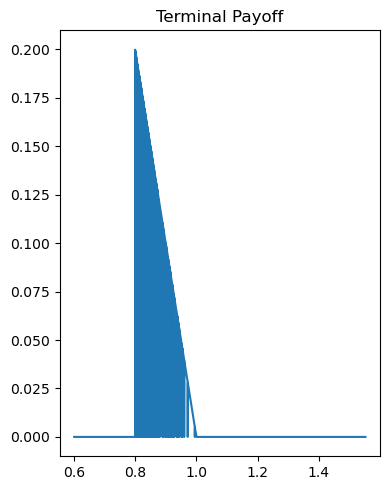

In [2]:
print("Deep Hedging AI says hello ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
import numpy as np

from cdxbasics.dynaplot import figure
from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world

def barrier_option( spots ):
    """ DKO Put
    
        Parameters
        ----------
            spots : spots of the equity[None,nSteps]
            
        Returns
        -------
            Payoff [None]
    """
    pcent      = 0.2
    put_strike = 1.0
    lower_KO   = 1.-pcent
    upper_KO   = 1.+pcent
    terminal   = np.maximum( put_strike - spots[:,-1], 0. )  # put
    lower      = np.where( np.min( spots, axis=1 ) >= lower_KO, 1., 0. )
    upper      = np.where( np.max( spots, axis=1 ) <= upper_KO, 1., 0. )
    return terminal*lower*upper

config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = True
config.world.payoff = barrier_option
# gym
config.gym.objective.utility = "exp2"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
config.gym.agent.recurrence = 0 # no recurrent nodes
# trainer
config.trainer.train.optimizer.name = "adam"
config.trainer.train.optimizer.learning_rate = 0.001
config.trainer.train.optimizer.clipvalue = 1.
config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = 2000
config.trainer.train.epochs = 8000
config.trainer.caching.mode = "on"
config.trainer.caching.epoch_freq = 100
config.trainer.visual.epoch_refresh = 20
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75
config_recurrent = config.copy()

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//10)

fig = figure()
ax  = fig.add_subplot()
ax.set_title("Terminal Payoff")
spotsT = world.details.spot_all[:,-1]
payoff = world.data.market.payoff
ixs    = np.argsort(spotsT)
spotsT = spotsT[ixs]
payoff = payoff[ixs]
ax.plot( spotsT,payoff )
fig.render()
fig.close()

## Hedging a barrier without recurrence

Gym with 944 trainable weights compiled and initialized. Took 3s
Agent is using 942 weights: 941 for the main agent per step, 1 for initial delta.
 Features available per time step: action, cost, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
                     thereof used: delta, price and time_left
      available for initial delta: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
                     thereof used: -
Monetary utility exp2@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/0d1e5231cea19b6ef711771e1e787cd2.pck'
Cache successfully loaded. Current epoch: 7999
Nothing to do: cached model loaded from /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/0d1e5231cea19b6ef711771e1e787cd2.pck was trained for 8000 epochs; you have asked to train fo

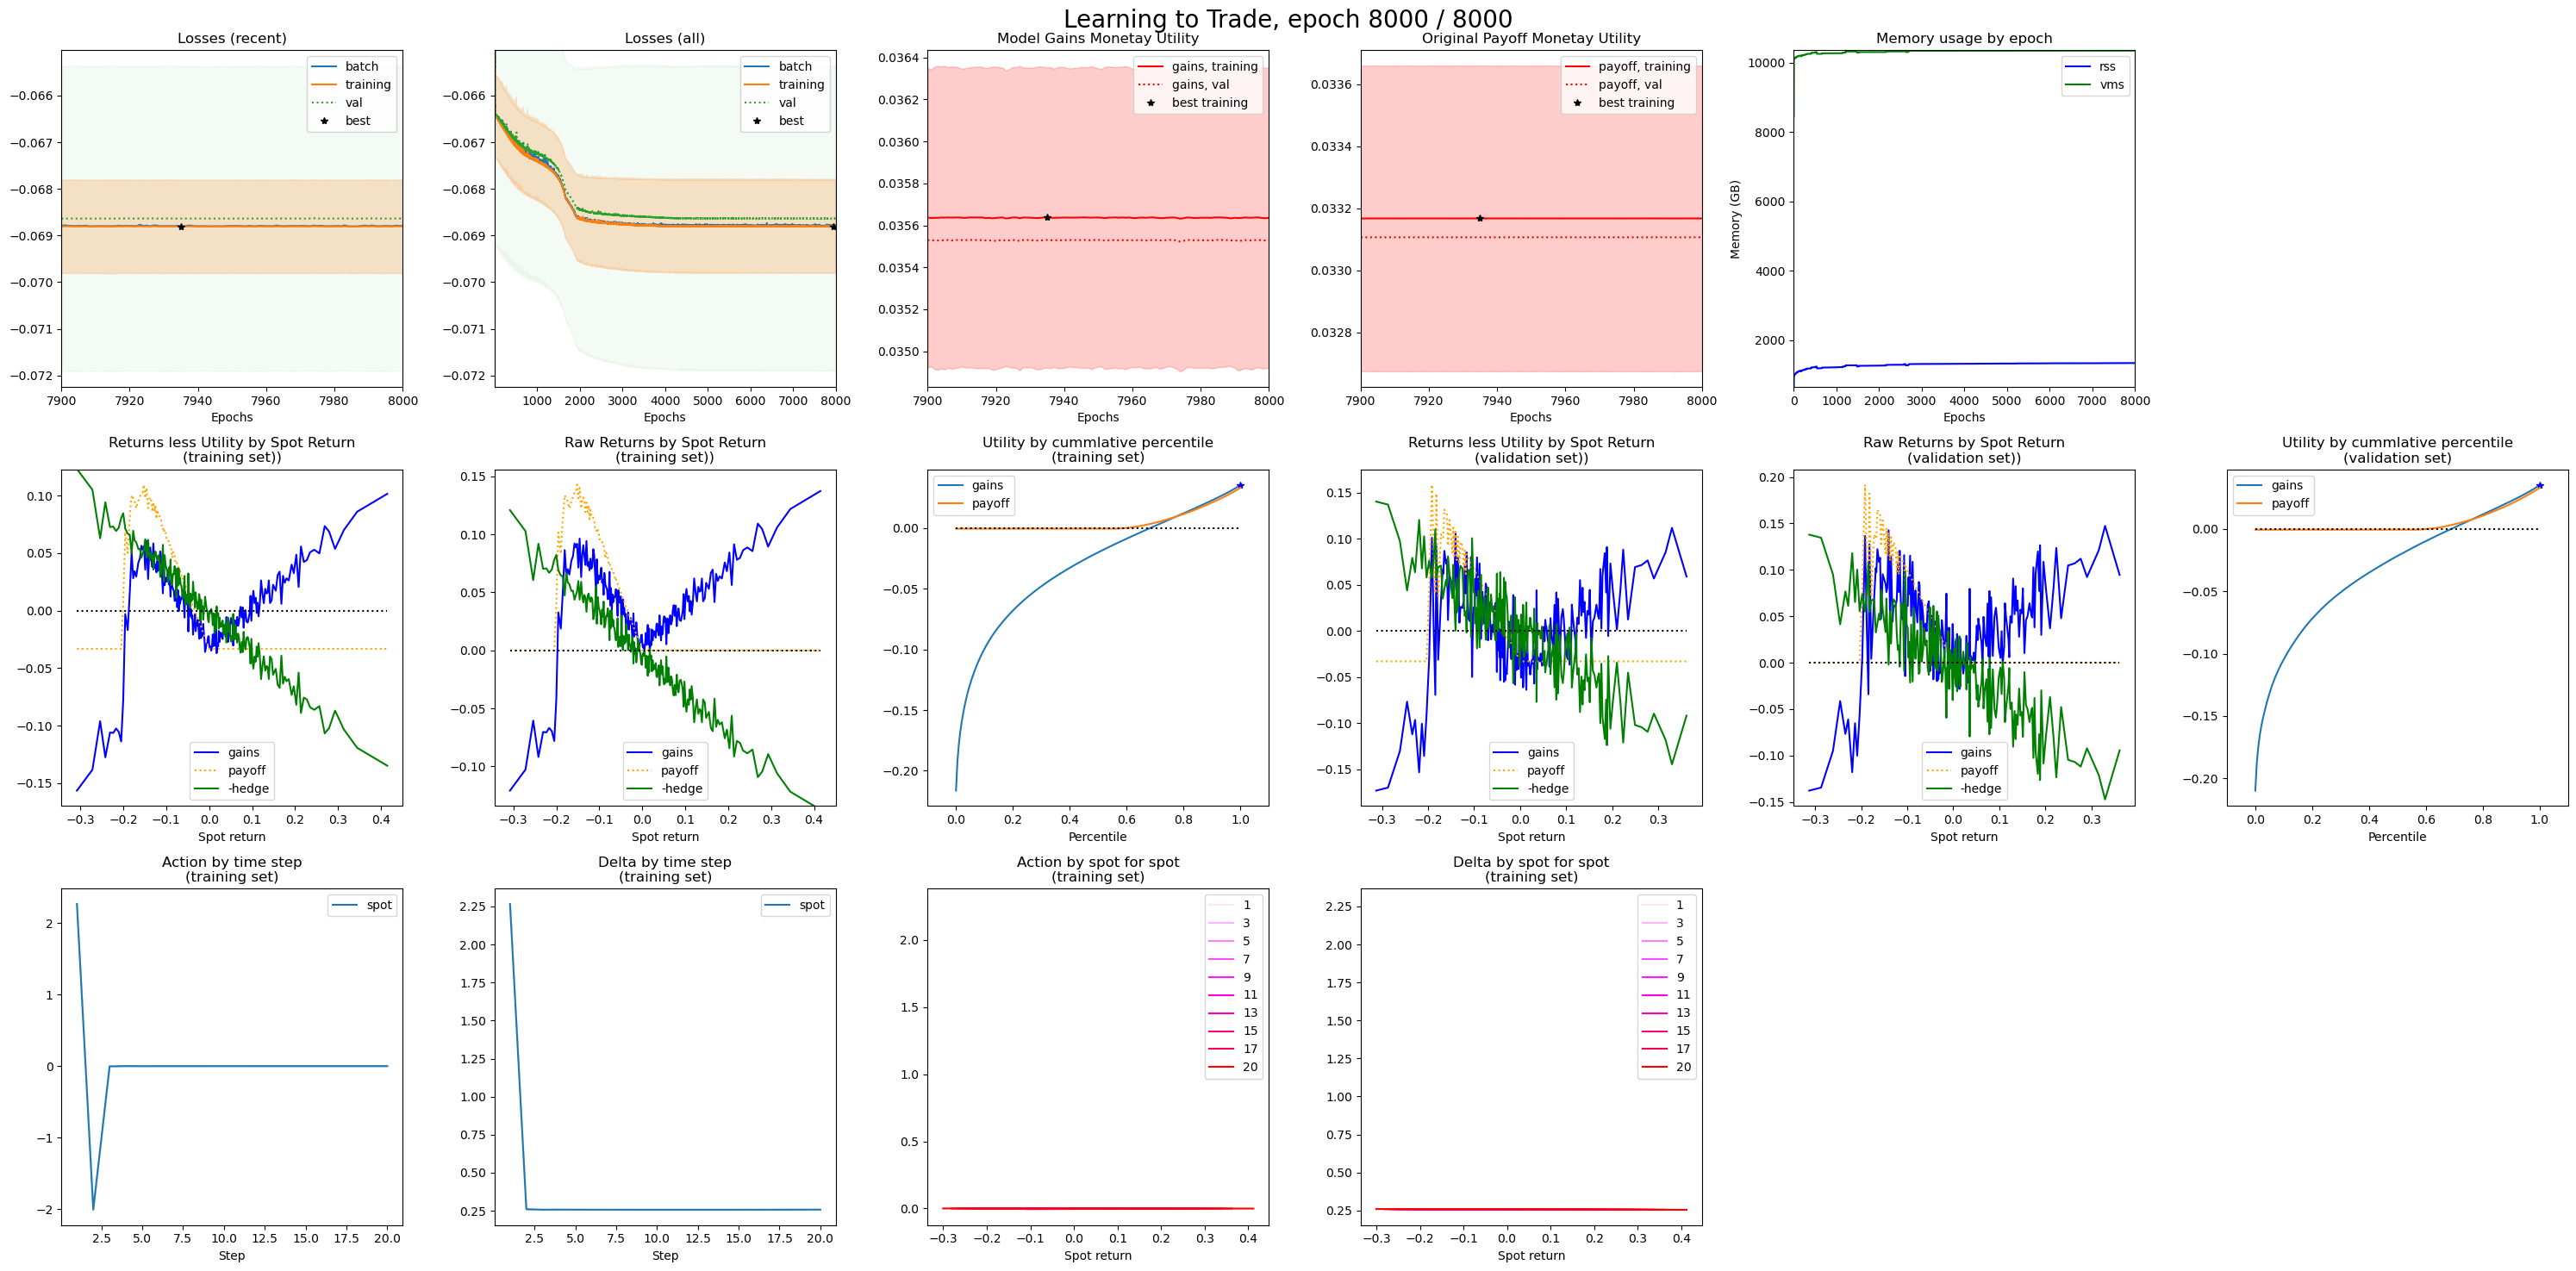

Training 8000/8000 epochs; 944 weights; 10000 samples; 1000 validation samples batch size 2000 | initial loss 0.164998 (0.00918834), training -0.0688034 (0.00100157), best -0.0688052 (0.00918834), batch -0.0687942, val -0.0686354 (0.00326887). Best epoch 7934; last cached 7999. | memory used: rss 1340.71M, vms 10353.2M | time elapsed 41:22; time per epoch 0s; estimated time remaining 0s                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 7934
 State of training until epoch 7999 cached into /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/0d1e5231cea19b6ef711771e1e787cd2.pck

Training terminated. Total time taken 6s


In [3]:
# create training environment
display(Markdown("## Hedging a barrier without recurrence"))
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
config.done()

## Hedging a barrier with recurrence

Gym with 1364 trainable weights compiled and initialized. Took 0s
Agent is using 1362 weights: 1351 for the main agent per step, 1 for initial delta, 10 for the initial state.
 Features available per time step: action, cost, delta, ivol, lbnd_a, pnl, price, recurrent_state, spot, sqrt_time_left, time_left and ubnd_a
                     thereof used: delta, price, recurrent_state and time_left
      available for initial delta: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
                     thereof used: -
      available for initial state: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
        0               thereof used: -
Monetary utility exp2@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/496c8ebf0c7af288eca1ba0e944e9a0c.pck'
Cache successfully loaded. Current ep

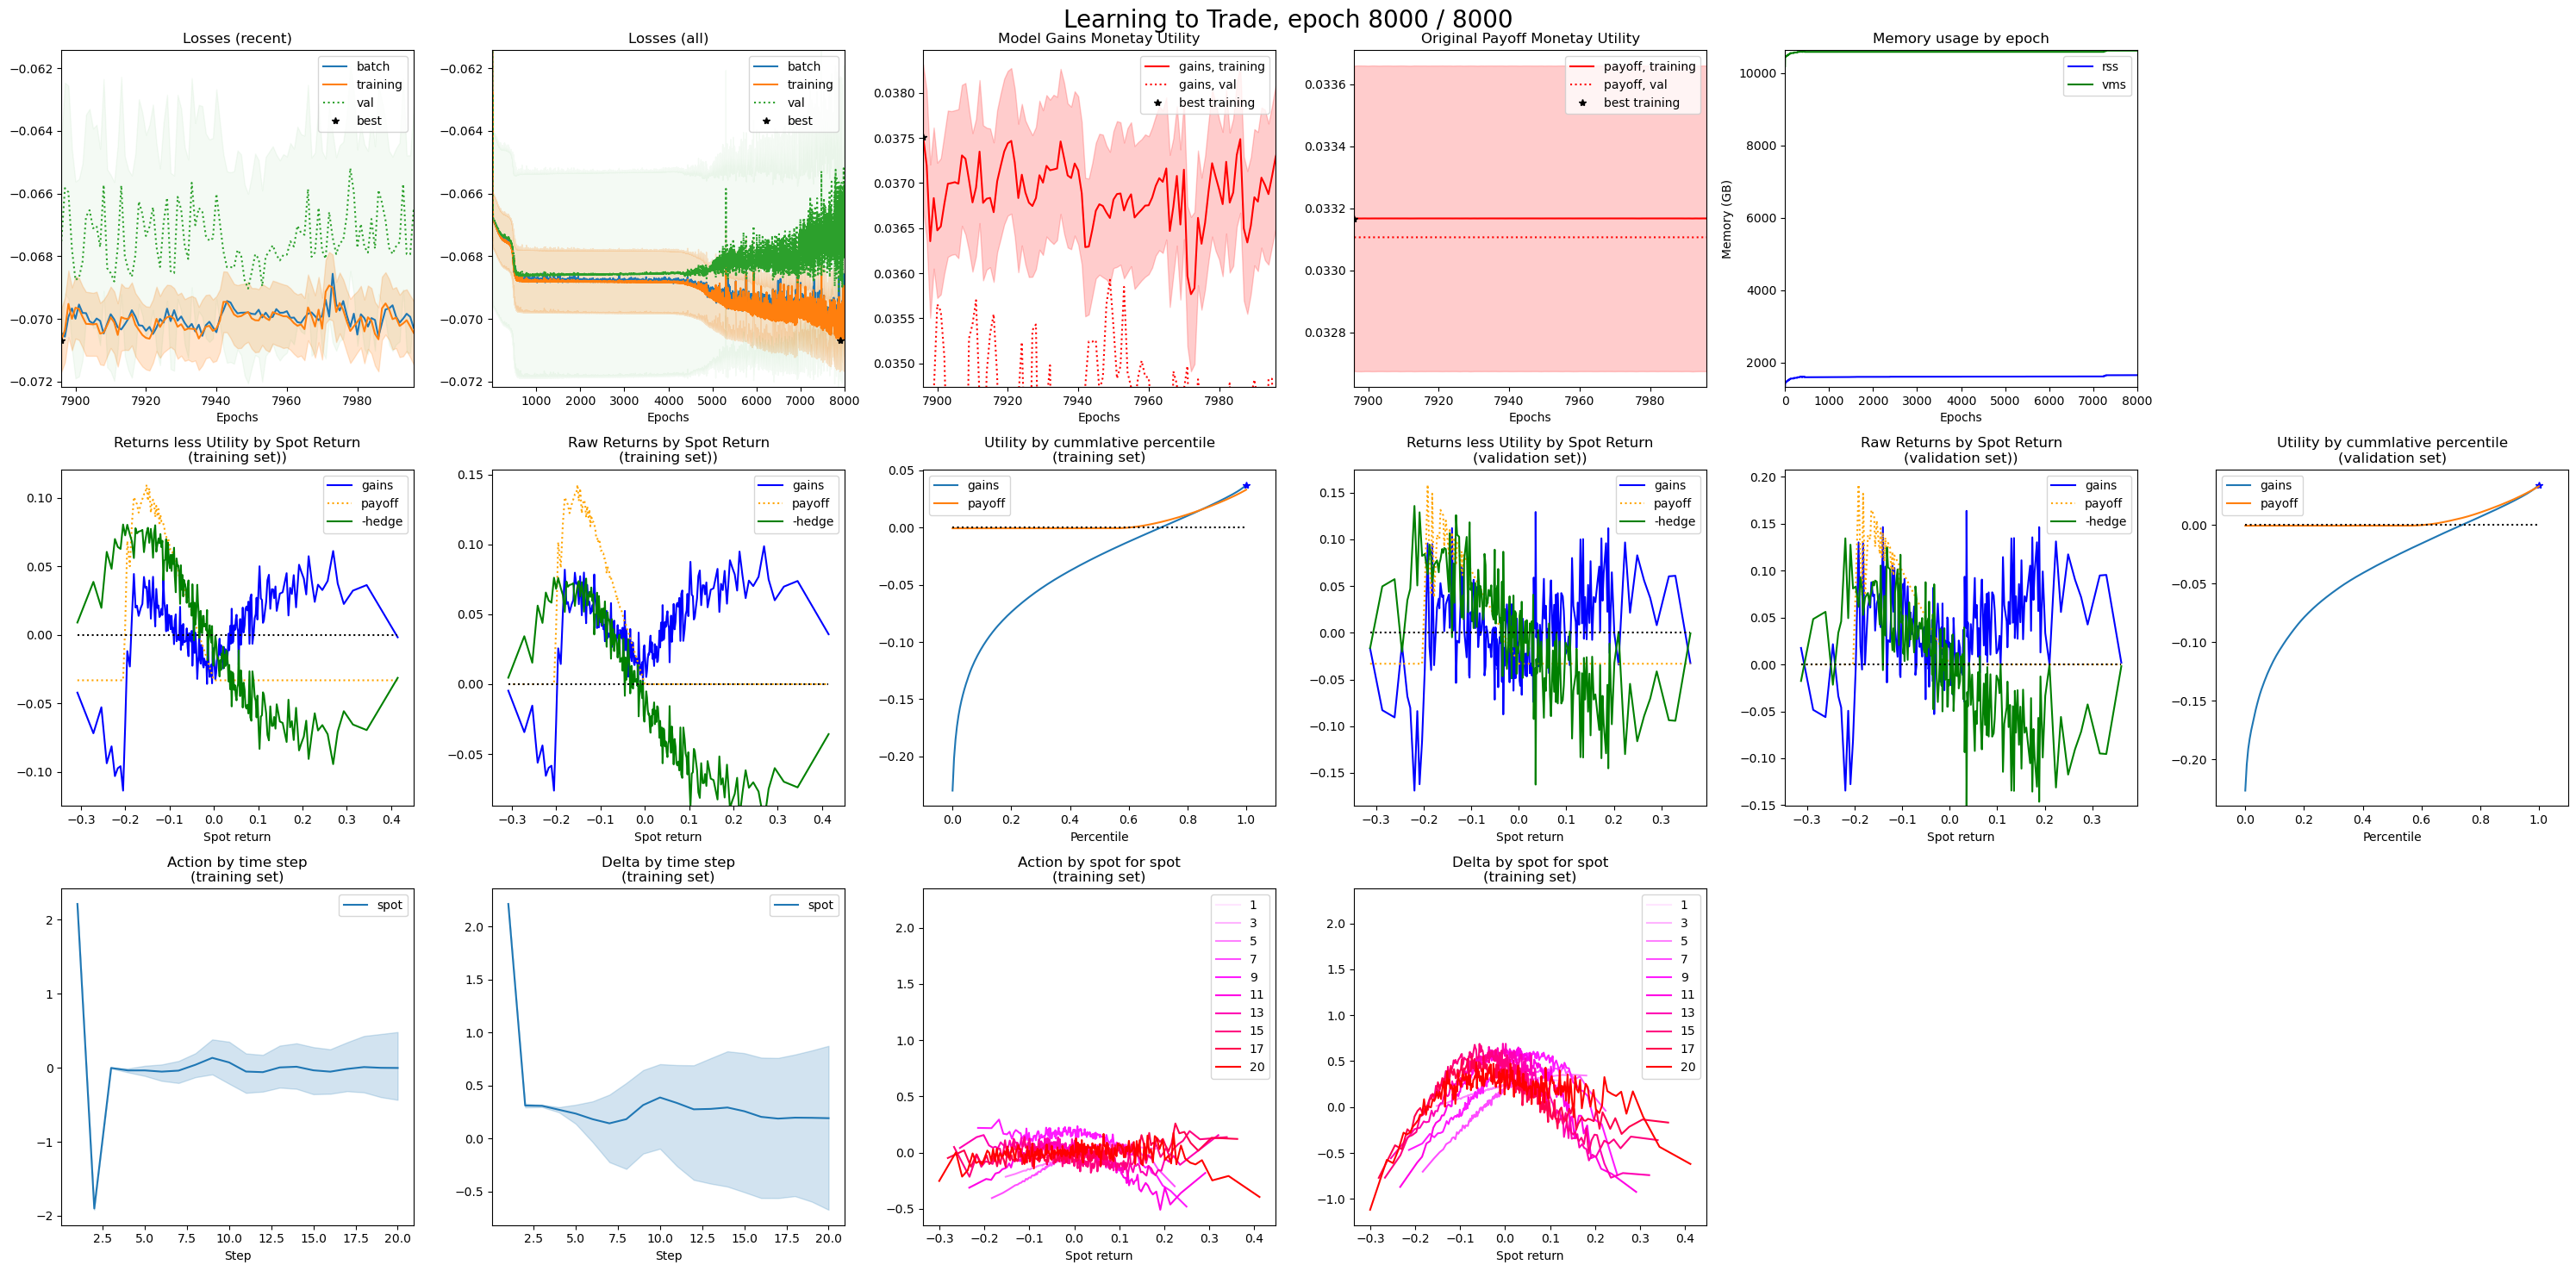

Training 8000/8000 epochs; 1364 weights; 10000 samples; 1000 validation samples batch size 2000 | initial loss 0.161024 (0.00909436), training -0.0705936 (0.00102313), best -0.0706802 (0.00909436), batch -0.0702455, val -0.0668604 (0.00330815). Best epoch 7895; last cached 7999. | memory used: rss 1652.64M, vms 10618.3M | time elapsed 43:38; time per epoch 0s; estimated time remaining 0s                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 7895
 State of training until epoch 7999 cached into /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/496c8ebf0c7af288eca1ba0e944e9a0c.pck

Training terminated. Total time taken 5s


In [4]:
config_recurrent.gym.agent.recurrence = 10 # recurrent nodes
config = config_recurrent

display(Markdown("## Hedging a barrier with recurrence"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//10)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
config.done()